In [1]:
import matplotlib.pyplot as plt

import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy

np.set_printoptions(suppress=True)
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 
import seaborn as sns 
sns.set_palette("husl") #设置所有图的颜色，使用hls色彩空间
import numpy as np
from sklearn import metrics
from sklearn.metrics import mean_squared_error #均方误差
from sklearn.metrics import mean_absolute_error #平方绝对误差

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR

In [2]:
# 读取BCHAIN-MKPRU.csv文件
df_BM = pd.read_csv('BCHAIN-MKPRU.csv', encoding='utf-8')
# 读取LBMA-GOLD.csv文件
df_GOLD = pd.read_csv('LBMA-GOLD.csv', encoding='utf-8')

# 通过简单的观察，采用Date字段合并数据，采用merge连接
df = pd.merge(df_BM, df_GOLD, how='outer', on='Date')
# 格式化时间 文件的时间格式是 月/日/年 -> 20xx/月/日
df["Date"] = df["Date"].apply(lambda x: time.strftime('%Y/%m/%d %H:%M:%S', time.strptime(x, '%m/%d/%y')))
# 排序Date字段
df = df.sort_values("Date")
df


,Date,Value,USD (PM)
0,2016/09/11 00:00:00,621.65,NaN
1,2016/09/12 00:00:00,609.67,1324.60
2,2016/09/13 00:00:00,610.92,1323.65
3,2016/09/14 00:00:00,608.82,1321.75
4,2016/09/15 00:00:00,610.38,1310.80
...,...,...,...
1821,2021/09/06 00:00:00,51769.06,1821.60
1822,2021/09/07 00:00:00,52677.40,1802.15
1823,2021/09/08 00:00:00,46809.17,1786.00
1824,2021/09/09 00:00:00,46078.38,1788.25


In [3]:
#查看缺失值
#比特币可以每天交易，但黄金仅在开市日交易
df.isnull().sum()

Date          0
Value         0
USD (PM)    571
dtype: int64

In [4]:
df.columns=['Date','BCHAIN-MKPRU','GOLD']

In [5]:
#计算日收益率
df['GOLD_fillna']=df['GOLD'].fillna(method='bfill')

In [6]:
# 计算每日收益率
stock_data = df[['BCHAIN-MKPRU','GOLD_fillna']].pct_change()
# 打印前5行数据
stock_data.head()

,BCHAIN-MKPRU,GOLD_fillna
0,NaN,NaN
1,-0.019271,0.000000
2,0.002050,-0.000717
3,-0.003437,-0.001435
4,0.002562,-0.008284


In [58]:
df['BCHAIN日收益率']=stock_data['BCHAIN-MKPRU']
df['GOLD日收益率']=stock_data['GOLD_fillna']

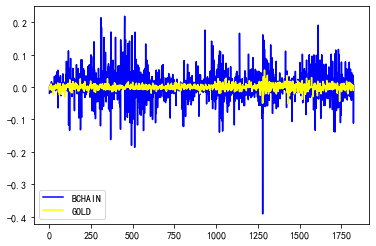

In [59]:
df['BCHAIN日收益率'].plot(label='BCHAIN',color='blue')
df['GOLD日收益率'].plot(label='GOLD',color='yellow')
plt.legend()
plt.show()

In [9]:
df

,Date,BCHAIN-MKPRU,GOLD,GOLD_fillna,BCHAIN日收益率,GOLD日收益率
0,2016/09/11 00:00:00,621.65,NaN,1324.60,NaN,NaN
1,2016/09/12 00:00:00,609.67,1324.60,1324.60,-0.019271,0.000000
2,2016/09/13 00:00:00,610.92,1323.65,1323.65,0.002050,-0.000717
3,2016/09/14 00:00:00,608.82,1321.75,1321.75,-0.003437,-0.001435
4,2016/09/15 00:00:00,610.38,1310.80,1310.80,0.002562,-0.008284
...,...,...,...,...,...,...
1821,2021/09/06 00:00:00,51769.06,1821.60,1821.60,0.036472,0.000000
1822,2021/09/07 00:00:00,52677.40,1802.15,1802.15,0.017546,-0.010677
1823,2021/09/08 00:00:00,46809.17,1786.00,1786.00,-0.111399,-0.008962
1824,2021/09/09 00:00:00,46078.38,1788.25,1788.25,-0.015612,0.001260


In [63]:
#时序数据滑窗转换用于将时间序列数据转为回归数据，简单地说，就是把一个单序列的数据变为X->Y的回归数据。

#步阶为2代表2个X（步阶多少就有多少个X），一个Y（这个不会变的），

#简单地说，就是用第1，2天的数据预测第3天，用第2，3天的数据预测第4天，以此类推。
def create_dataset(dataset, look_back):

    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
        dddd=pd.concat([pd.DataFrame(np.array(dataY)),pd.DataFrame(np.array(dataX))],axis=1)
        dddd.columns=['Y']+['shiftX_'+str(i) for i in range(len(dddd.columns)-1)]
    return dddd
data1=create_dataset(df_BM['Value'],look_back=1)
data1

,Y,shiftX_0
0,609.67,621.65
1,610.92,609.67
2,608.82,610.92
3,610.38,608.82
4,609.11,610.38
...,...,...
1819,49947.38,50035.33
1820,51769.06,49947.38
1821,52677.40,51769.06
1822,46809.17,52677.40


In [11]:

'''
随机森林回归
'''

from sklearn.metrics import r2_score


def score(y_true, y_pre):
    # MSE
    print("MSE :")
    print(metrics.mean_squared_error(y_true, y_pre)) 
    # RMSE
    print("RMSE :")
    print(np.sqrt(metrics.mean_squared_error(y_true, y_pre))) 
    # MAE
    print("MAE :")
    print(metrics.mean_absolute_error(y_true, y_pre)) 
    # R2
    print("R2 :")
    print(r2_score(y_true,y_pre)) 


In [44]:
from sklearn.model_selection import train_test_split
X=data1['shiftX_0'].values.reshape(-1, 1)
Y=data1['Y'].values.reshape(-1, 1)

train_X,test_X,train_y,test_y = train_test_split(X,Y,test_size=0.3,random_state=42)


model_rf = RandomForestRegressor()
model_rf.fit(train_X,train_y)

score(test_y, model_rf.predict(test_X))

MSE :
303.09559866188545
RMSE :
17.409640968781794
MAE :
12.135415428316119
R2 :
0.9951470888148953


C:\Users\86137\AppData\Local\Temp/ipykernel_7496/348318555.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(train_X,train_y)


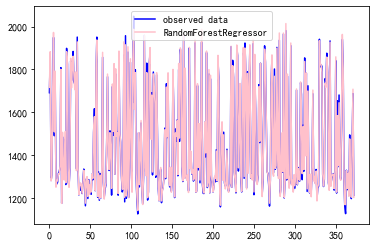

In [52]:
plt.plot(test_y,color='blue', label='observed data')
plt.plot(model_rf.predict(test_X), color='pink', label='RandomForestRegressor')

plt.legend() # 显示图例
plt.show()

In [14]:
df_BM['Value']=pd.DataFrame(model_rf.predict(df_BM['Value'].values.reshape(-1, 1)),columns=['Value'])

In [15]:
data1=create_dataset(df_GOLD['USD (PM)'],look_back=1)
data1.dropna(inplace=True)
data1

,Y,shiftX_0
0,1323.65,1324.60
1,1321.75,1323.65
2,1310.80,1321.75
3,1308.35,1310.80
4,1314.85,1308.35
...,...,...
1258,1823.70,1812.55
1259,1821.60,1823.70
1260,1802.15,1821.60
1261,1786.00,1802.15


In [43]:
X=data1['shiftX_0'].values.reshape(-1, 1)
Y=data1['Y'].values.reshape(-1, 1)

train_X,test_X,train_y,test_y = train_test_split(X,Y,test_size=0.3,random_state=42)


model_rf = RandomForestRegressor()
model_rf.fit(train_X,train_y)

score(test_y, model_rf.predict(test_X))

MSE :
298.0176660959379
RMSE :
17.263188178779085
MAE :
12.061655998659562
R2 :
0.9952283923899234


C:\Users\86137\AppData\Local\Temp/ipykernel_7496/3875077581.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(train_X,train_y)


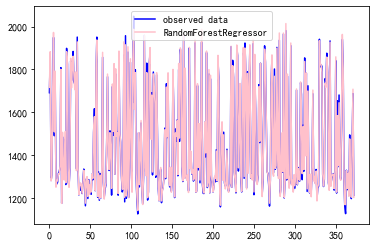

In [53]:
plt.plot(test_y,color='blue', label='observed data')
plt.plot(model_rf.predict(test_X), color='pink', label='RandomForestRegressor')

plt.legend() # 显示图例
plt.show()

In [18]:
df_GOLD['USD (PM)']=pd.DataFrame(model_rf.predict(df_GOLD['USD (PM)'].fillna(method='bfill').values.reshape(-1, 1)),columns=['USD (PM)'])

In [19]:
# 通过简单的观察，采用Date字段合并数据，采用merge连接
df = pd.merge(df_BM, df_GOLD, how='outer', on='Date')
# 格式化时间 文件的时间格式是 月/日/年 -> 20xx/月/日
df["Date"] = df["Date"].apply(lambda x: time.strftime('%Y/%m/%d %H:%M:%S', time.strptime(x, '%m/%d/%y')))
# 排序Date字段
df = df.sort_values("Date")
df.fillna(method='bfill',inplace=True)
df

,Date,Value,USD (PM)
0,2016/09/11 00:00:00,612.2020,1323.118000
1,2016/09/12 00:00:00,611.5017,1323.118000
2,2016/09/13 00:00:00,609.3512,1322.627300
3,2016/09/14 00:00:00,602.1532,1314.136000
4,2016/09/15 00:00:00,609.2558,1317.331914
...,...,...,...
1821,2021/09/06 00:00:00,53595.5497,1834.995500
1822,2021/09/07 00:00:00,48678.2440,1795.657500
1823,2021/09/08 00:00:00,46263.5249,1800.365000
1824,2021/09/09 00:00:00,45148.7077,1788.913500


In [20]:
df_append=pd.DataFrame(np.insert(df['Date'].values, 1826, values='2021/09/11 00:00:00', axis=0),columns=['Date'])
df_append['Value']=pd.DataFrame(np.insert(df['Value'].values, 0, values=np.nan, axis=0))
df_append['USD (PM)']=pd.DataFrame(np.insert(df['USD (PM)'].values, 0, values=np.nan, axis=0))
df_append
#向下滑动偏移，因为从2016/09/11 开始预测2016/09/12

,Date,Value,USD (PM)
0,2016/09/11 00:00:00,NaN,NaN
1,2016/09/12 00:00:00,612.2020,1323.1180
2,2016/09/13 00:00:00,611.5017,1323.1180
3,2016/09/14 00:00:00,609.3512,1322.6273
4,2016/09/15 00:00:00,602.1532,1314.1360
...,...,...,...
1822,2021/09/07 00:00:00,53595.5497,1834.9955
1823,2021/09/08 00:00:00,48678.2440,1795.6575
1824,2021/09/09 00:00:00,46263.5249,1800.3650
1825,2021/09/10 00:00:00,45148.7077,1788.9135


In [21]:

from sko.operators import ranking, selection, crossover, mutation
from sko.GA import GA


In [22]:
# 黄金持有
z1 = 500
# 比特币持有
z2 = 500
# m1 今日黄金价格
m1 = 1324.2576

# m2 今日比特币价格
m2 = 773.88040
# n1 明日黄金价格
n1 = 1323.3617
# n2 明日比特币价格
n2 = 774.83980



In [23]:

def model_1_ga(z1,z2,m1,m2,n1,n2):
    demo_func = lambda x: -((n1 / m1) * (z1 + x[0]) + (n2 / m2) * (z2 + x[1]))
    constraint_ueq = [
    lambda x: x[0] + x[1] - (z1 + z2),
    lambda x: (-z1 - z2) - (x[0] + x[1]),
    lambda x: 0.01*x[0] - ((n1 / m1) - 1),
    lambda x: 0.02*x[1] - ((n2 / m2) - 1)
    ]
    ga = GA(func=demo_func, n_dim=2, size_pop=100, max_iter=500, prob_mut=0.001,
    lb=[-z1, -z2], ub=[z1, z2], precision=[1e-7, 1e-7], constraint_ueq=constraint_ueq)
    ga.register(operator_name='selection', operator=selection.selection_roulette_2)
    ga.register(operator_name='ranking', operator=ranking.ranking). \
    register(operator_name='crossover', operator=crossover.crossover_2point_bit). \
    register(operator_name='mutation', operator=mutation.mutation)
    best_x, func = ga.run()

    return -func[0],best_x[0],best_x[1]
#下面这个代码是测试用的
model_1_ga(z1,z2,m1,m2,n1,n2)
#测试用的，忽略

(1000.2540693527891, -0.07570555317653316, 0.0480658782208252)

In [32]:
%%time


def model_2_ga(z1,z2,m2,n2):

    demo_func = lambda x: -(z1 + (n2 / m2) * (z2 + x[0]))


    constraint_ueq = [
        lambda x: x[0] - z2,
        lambda x: - z2 - x[0],
        lambda x: 0.02*x[0]  - ((n2 / m2) - 1)
    ]
    ga = GA(func=demo_func, n_dim=1, size_pop=100, max_iter=500, prob_mut=0.001,
            lb=[-z1], ub=[z1], precision=[1e-7], constraint_ueq=constraint_ueq)

    ga.register(operator_name='selection', operator=selection.selection_roulette_2)
    ga.register(operator_name='ranking', operator=ranking.ranking). \
        register(operator_name='crossover', operator=crossover.crossover_2point_bit). \
        register(operator_name='mutation', operator=mutation.mutation)
    best_x, func = ga.run()
    return -func[0],best_x[0]+
#下面这个代码是测试用的
model_2_ga(z1,z2,n1,n2)

#测试用的，忽略

SyntaxError: invalid syntax (<unknown>, line 19)

In [42]:
# 读取BCHAIN-MKPRU.csv文件
df_BM = pd.read_csv('BCHAIN-MKPRU.csv', encoding='utf-8')
# 读取LBMA-GOLD.csv文件
df_GOLD = pd.read_csv('LBMA-GOLD.csv', encoding='utf-8')

# 通过简单的观察，采用Date字段合并数据，采用merge连接
newdf = pd.merge(df_BM, df_GOLD, how='outer', on='Date')
# 格式化时间 文件的时间格式是 月/日/年 -> 20xx/月/日
newdf["Date"] = newdf["Date"].apply(lambda x: time.strftime('%Y/%m/%d %H:%M:%S', time.strptime(x, '%m/%d/%y')))
# 排序Date字段
newdf = newdf.sort_values("Date")
newdf

# 通过简单的观察，采用Date字段合并数据，采用merge连接
df___ = pd.merge(df_append, newdf, how='left', on='Date')
df___.columns=['Date','Predicted bitcoin price','Predicted gold price','Actual bitcoin price','Actual gold price']
df___

,Date,Predicted bitcoin price,Predicted gold price,Actual bitcoin price,Actual gold price
0,2016/09/11 00:00:00,NaN,NaN,621.65,NaN
1,2016/09/12 00:00:00,612.2020,1323.1180,609.67,1324.60
2,2016/09/13 00:00:00,611.5017,1323.1180,610.92,1323.65
3,2016/09/14 00:00:00,609.3512,1322.6273,608.82,1321.75
4,2016/09/15 00:00:00,602.1532,1314.1360,610.38,1310.80
...,...,...,...,...,...
1822,2021/09/07 00:00:00,53595.5497,1834.9955,52677.40,1802.15
1823,2021/09/08 00:00:00,48678.2440,1795.6575,46809.17,1786.00
1824,2021/09/09 00:00:00,46263.5249,1800.3650,46078.38,1788.25
1825,2021/09/10 00:00:00,45148.7077,1788.9135,46368.69,1794.60


In [34]:
df___['预测的比特币价格'].iloc[i]

NameError: name 'i' is not defined

In [35]:
z1,z2,m2,n2

(500, 500, 773.8804, 774.8398)

In [36]:
# 黄金持有
z1 = 500
# 比特币持有
z2 = 1000-z1
alldata=[]#算了还是重新跑

#估计跑一晚，就可以了
for i in range(1,df___.shape[0]):
    try:
        if i== df___.shape[0]-1:
            break
        # m1 真实的今日黄金价格
        m1=df___['真实的比黄金价格'].iloc[i]
        # m2 真实的今日比特币价格
        m2=df___['真实的比特币价格'].iloc[i]
        # n1 预测的明日黄金价格
        n1= df___['预测的比黄金价格'].iloc[i]
        # n2 预测的明日比特币价格
        n2= df___['预测的比特币价格'].iloc[i]
         # n1 真实的明日黄金价格
        N1= df___['真实的比黄金价格'].iloc[i+1]
        # n2 真实的明日比特币价格
        N2= df___['真实的比特币价格'].iloc[i+1] 
        if (np.isnan(m1)==True) or (np.isnan(n1)==True):
            ojb,x_bit=model_2_ga(z1,z2,m2,n2)
            z2=N2 / m2 * (z2 + x_bit)
            alldata.append([df___['Date'].iloc[i],m1,m2,n1,n2,N1,N2,z1,z2,np.nan,x_bit,ojb])
        else:
            ojb,x_hj,x_bit=model_1_ga(z1,z2,m1,m2,n1,n2)
            if (np.isnan(N1)==True) or (np.isnan(N2)==True):
                pass
            else:
                z1=N1 / m1 * (z1 + x_hj) 
                z2=N2 / m2 * (z2 + x_bit)
            alldata.append([df___['Date'].iloc[i],m1,m2,n1,n2,N1,N2,z1,z2,x_hj,x_bit,ojb])
        if z1==0 or np.isnan(z1)==True :
            z1=0.0001
        print('%s/1826'%(str(i+1)))
    except:
        print(df___['Date'].iloc[i])
        break
        #跑完了，接着再等2小时


2016/09/12 00:00:00


In [37]:
model_1_ga(z1,z2,m1,m2,n1,n2)

(999.7919012618556, -0.13135842164814449, -0.3579836047928211)

In [38]:
columns1=['交易日期','真实的今日黄金价格','真实的今日比特币价格','预测的明日黄金价格','预测的明日比特币价格', '真实的明日黄金价格','真实的明日比特币价格','本日黄金持有额(加上第二日的)','本日比特币持有额(加上第二日的)','本日黄金交易额','本日比特币交易额','当前交易日资产总值']
alldata=pd.DataFrame(alldata,columns=columns1)

In [39]:
alldata

,交易日期,真实的今日黄金价格,真实的今日比特币价格,预测的明日黄金价格,预测的明日比特币价格,真实的明日黄金价格,真实的明日比特币价格,本日黄金持有额(加上第二日的),本日比特币持有额(加上第二日的),本日黄金交易额,本日比特币交易额,当前交易日资产总值


In [40]:
alldata.to_excel('alldata.xlsx',index=None)

In [ ]:
#迭代以上流程
#我用Gpu跑2天
x=[]
y=[]
for i in range(1,1001,20):
    x.append(i)
    # 黄金持有
    z1 = i 
    # 比特币持有
    z2 = 1000-z1
    alldata=[]
    for i in range(df.shape[0]):
        try:
            if i== df___.shape[0]-1:
                break
            i=1825
            # m1 真实的今日黄金价格
            m1=df___['真实的比黄金价格'].iloc[i]
            # m2 真实的今日比特币价格
            m2=df___['真实的比特币价格'].iloc[i]
            # n1 预测的明日黄金价格
            n1= df___['预测的比黄金价格'].iloc[i]
            # n2 预测的明日比特币价格
            n2= df___['预测的比特币价格'].iloc[i]
             # n1 真实的明日黄金价格
            N1= df___['真实的比黄金价格'].iloc[i+1]
            # n2 真实的明日比特币价格
            N2= df___['真实的比特币价格'].iloc[i+1]

            if (np.isnan(m1)==True) or (np.isnan(n1)==True):
                ojb,x_bit=model_2_ga(z1,z2,m2,n2)
                z2=N2 / m2 * (z2 + x_bit)
                alldata.append([df___['Date'].iloc[i],m1,m2,n1,n2,N1,N2,z1,z2,np.nan,x_bit,ojb])
            else:
                ojb,x_hj,x_bit=model_1_ga(z1,z2,m1,m2,n1,n2)
                if (np.isnan(N1)==True) or (np.isnan(N2)==True):
                    pass
                else:
                    z1=N1 / m1 * (z1 + x_hj) 
                    z2=N2 / m2 * (z2 + x_bit)


                alldata.append([df___['Date'].iloc[i],m1,m2,n1,n2,N1,N2,z1,z2,x_hj,x_bit,ojb])
            if z1==0 or np.isnan(z1)==True :
                z1=0.0001
        except:
            print(df___['Date'].iloc[i])
            break
        y.append(ojb)

2021/09/10 00:00:00
2021/09/10 00:00:00
2021/09/10 00:00:00
2021/09/10 00:00:00


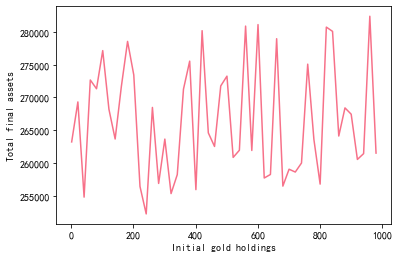

In [64]:
plt.plot(x,y)
plt.xlabel('Initial gold holdings')
plt.ylabel('Total final assets')
plt.show()